In [10]:
import stlearn as st
import scanpy as sc
import pandas as pd
import re
import numpy as np

from collections import Counter
from scipy.sparse import csr_matrix
import anndata as ad
import seaborn as sns
import harmonypy as hm
from matplotlib import pyplot as plt
from stlearn.spatials.clustering import localization

import gseapy as gp
from matplotlib.colors import LogNorm


plt.rcParams['figure.figsize'] = [6, 6]

In [11]:
paga_threshold = 0.1
sample = 'MEND160'

use_label = 'CNV_clusters'
input_path = 'hest_data/st/'

In [12]:
adata = sc.read_h5ad('hest_data/pseudotime/' + sample + '_pseudotime.h5ad')
branch_summary = pd.read_csv('hest_data/pseudotime/'+ sample + '_branch_summary.csv', index_col = 0)

In [13]:
pathway_enrichment = adata.uns['pathway_enrichment'] 

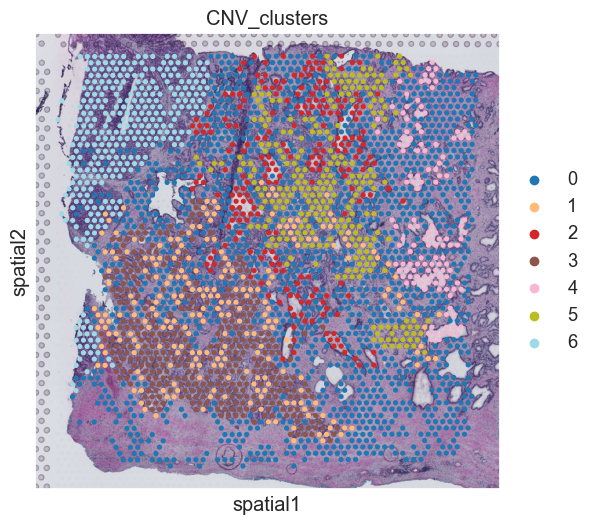

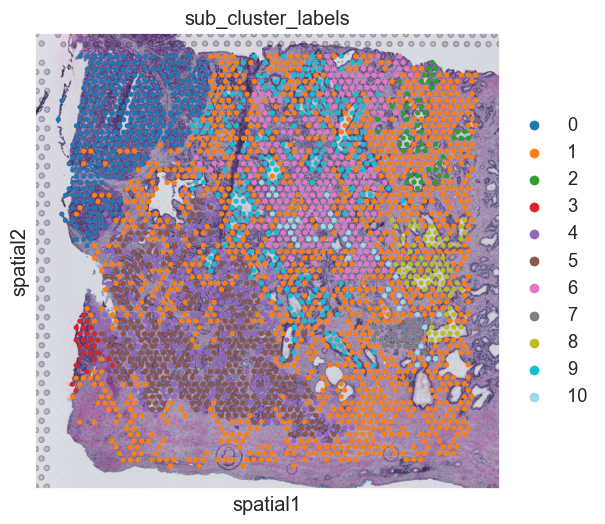

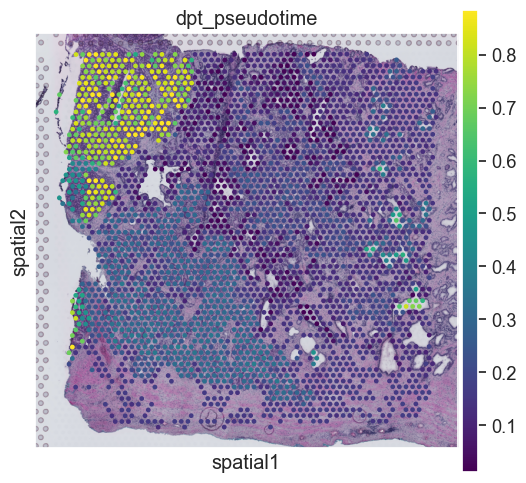

In [14]:
sc.pl.spatial(adata,
                # show first 8 cell types
                color=use_label,
                ncols=4, size=1.3,
                img_key="downscaled_fullres",
                # limit color scale at 99.2% quantile of cell abundance
                spot_size = adata.uns['spatial']['ST']['scalefactors']['spot_diameter_fullres'],
                palette = 'tab20')


sc.pl.spatial(adata,
                # show first 8 cell types
                color='sub_cluster_labels',
                ncols=4, size=1.3,
                img_key="downscaled_fullres",
                # limit color scale at 99.2% quantile of cell abundance
                spot_size = adata.uns['spatial']['ST']['scalefactors']['spot_diameter_fullres'],
                palette = 'tab20')

sc.pl.spatial(adata,
                # show first 8 cell types
                color=['dpt_pseudotime'],
                ncols=4, size=1.3,
                img_key="downscaled_fullres",
                # limit color scale at 99.2% quantile of cell abundance
                vmin='p1', vmax='p99',
                spot_size = adata.uns['spatial']['ST']['scalefactors']['spot_diameter_fullres'],
                cmap="viridis"
                )

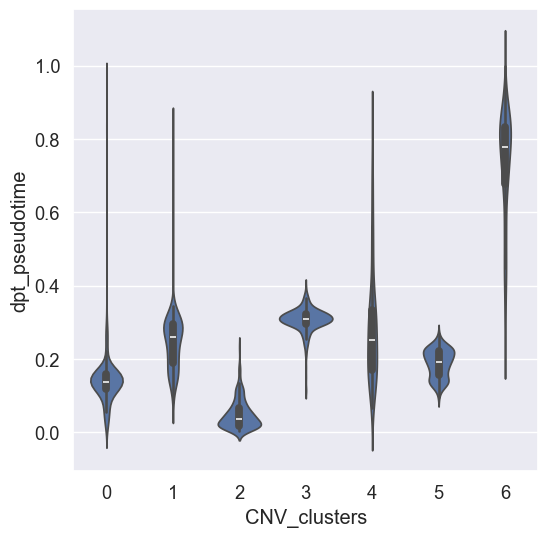

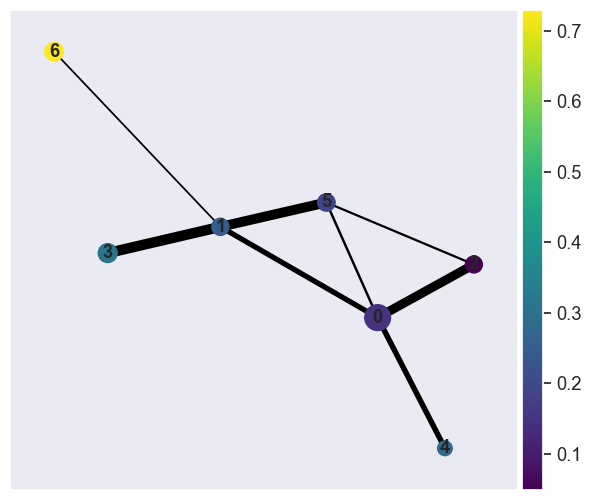

In [15]:
plot_data = pd.DataFrame({use_label: adata.obs[use_label], 'dpt_pseudotime': adata.obs['dpt_pseudotime']})
# Create the violin plot
sns.violinplot(x=use_label, y='dpt_pseudotime', data=plot_data)

sc.pl.paga(adata, color=['dpt_pseudotime'], threshold = paga_threshold, cmap="viridis")

C:\Users\masmel\AppData\Local\anaconda3\envs\stlearn2\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


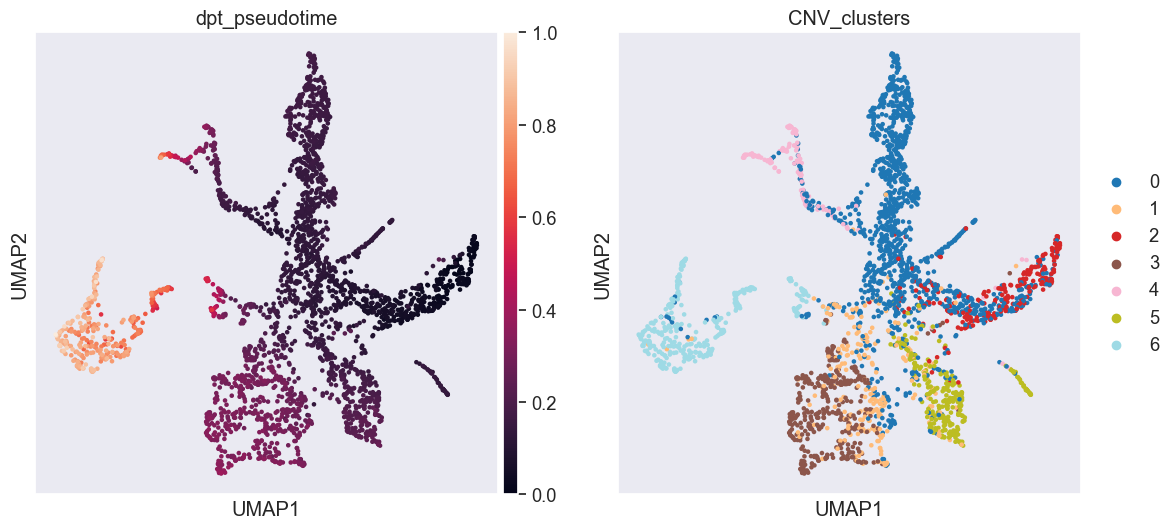

In [16]:
sc.tl.umap(adata)
sc.pl.umap(adata, color = ['dpt_pseudotime','CNV_clusters'] )

up
down
abs


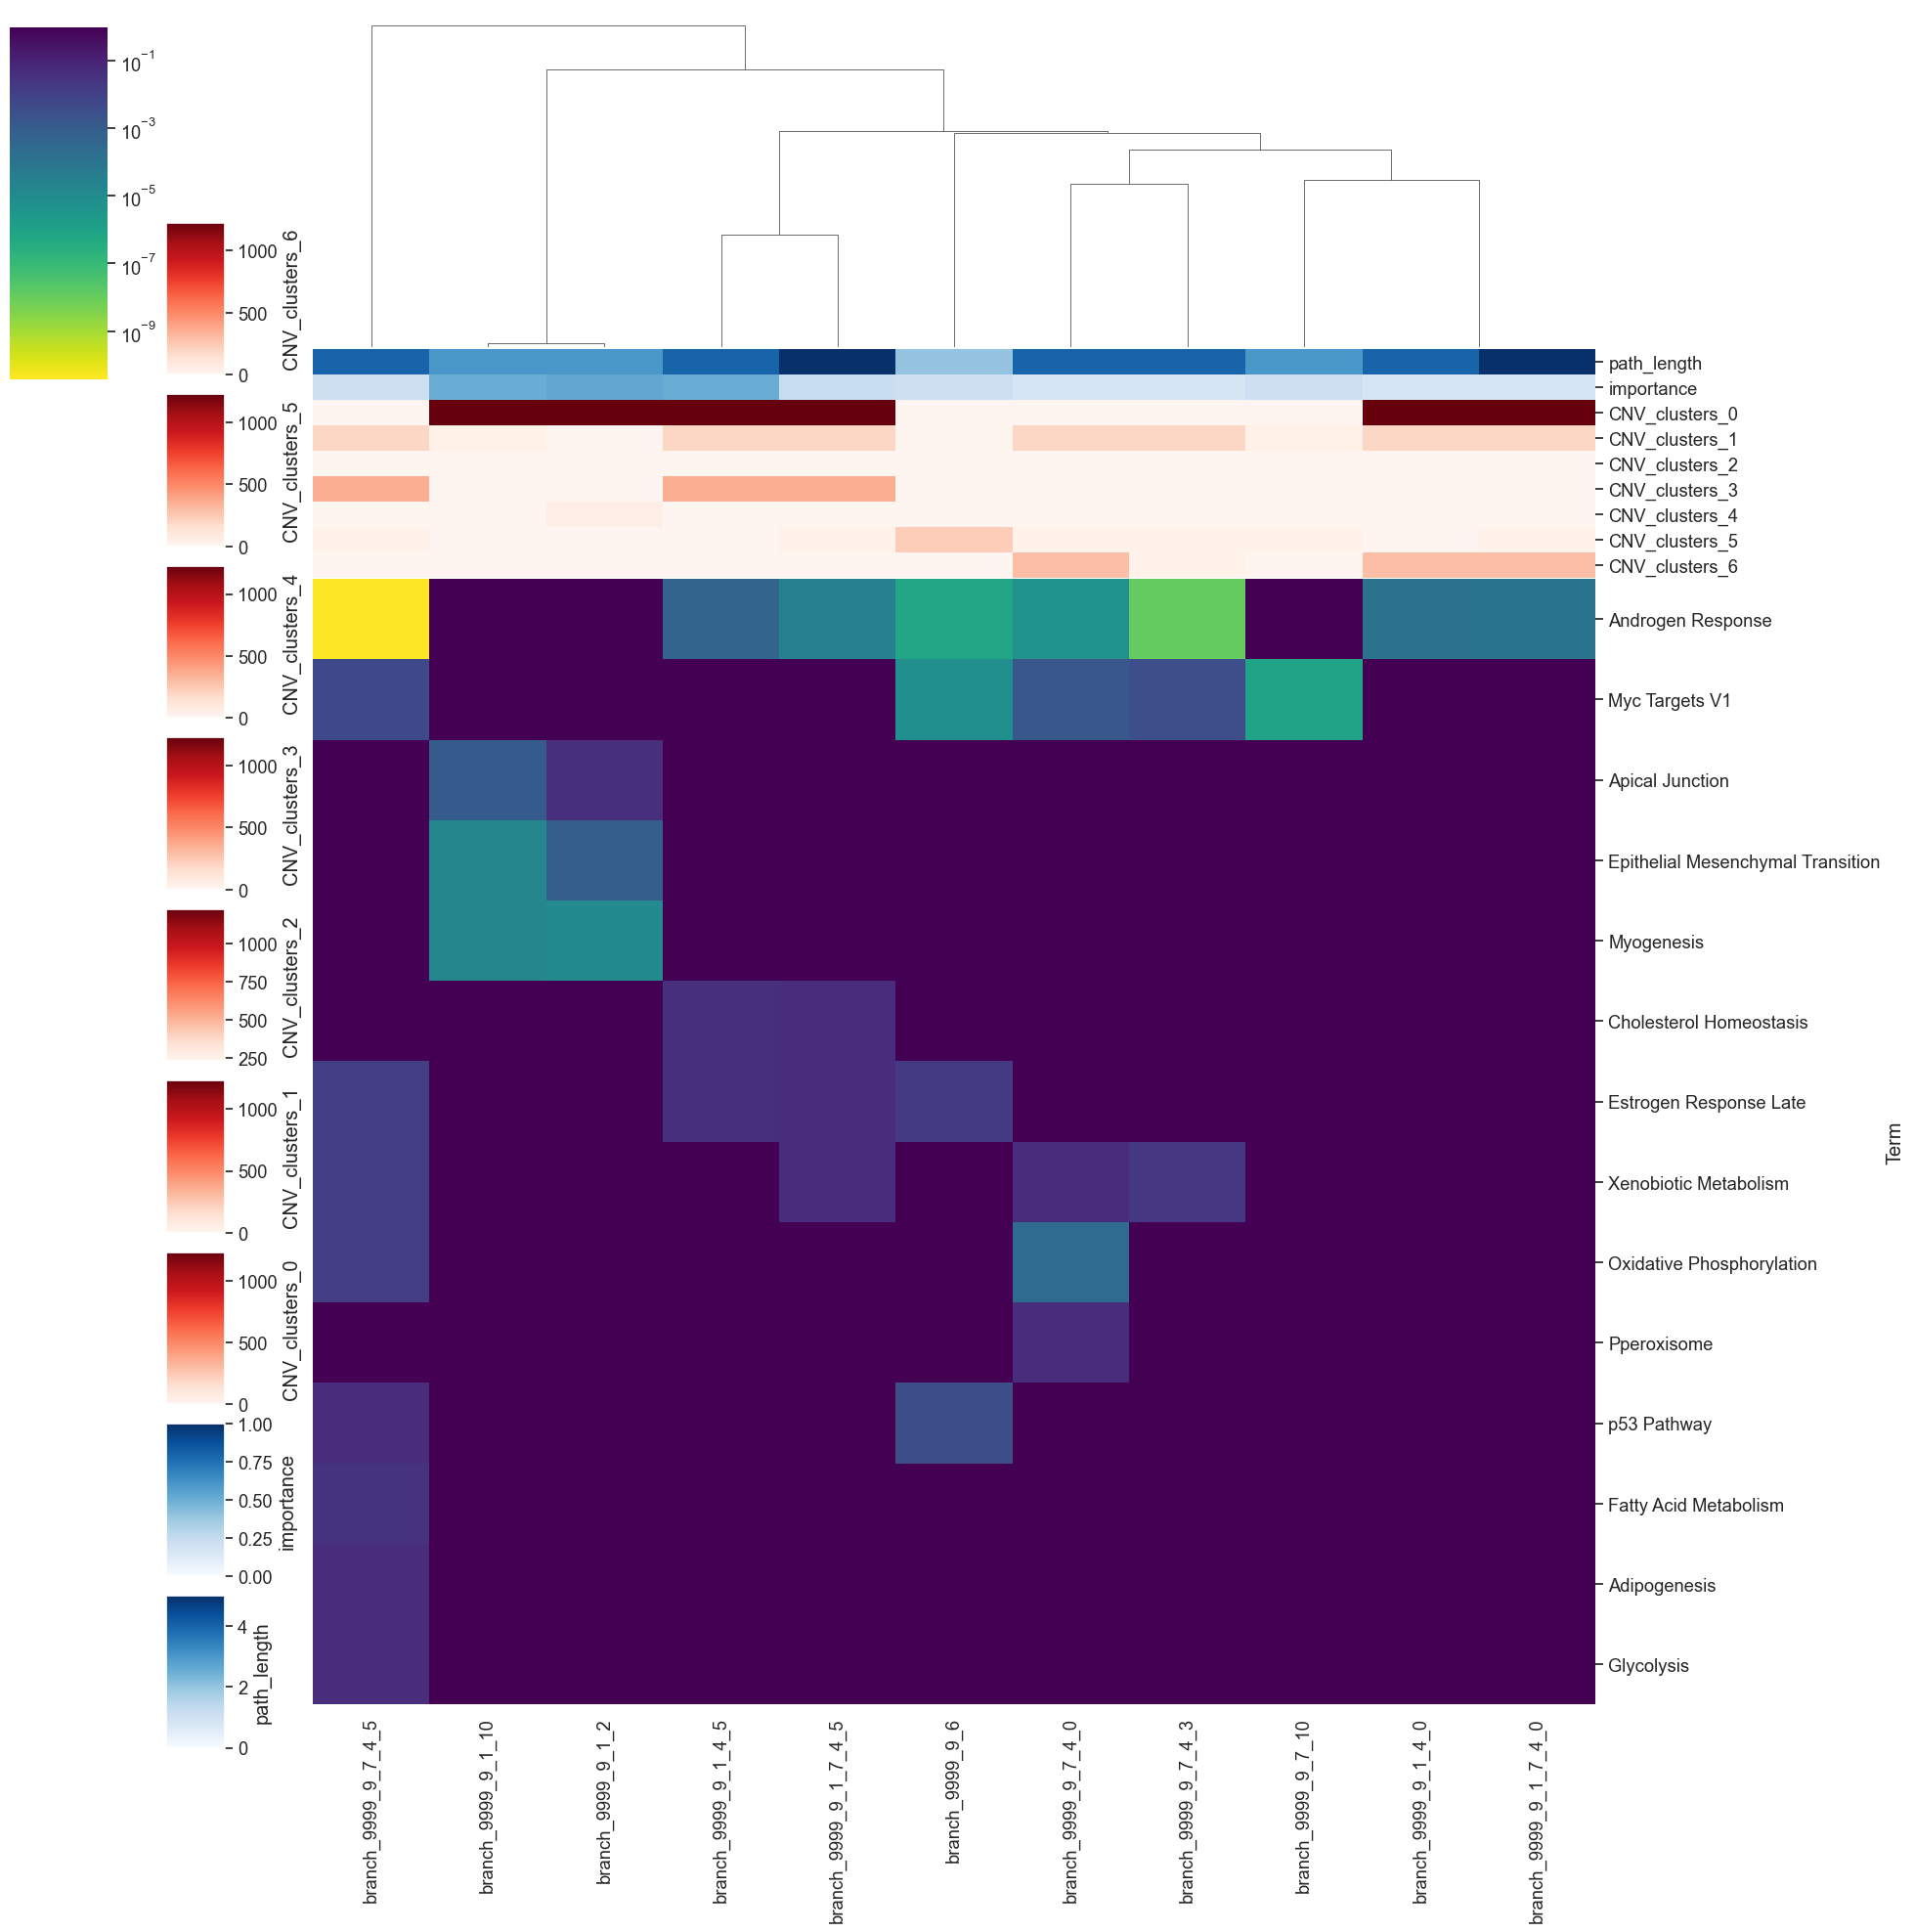

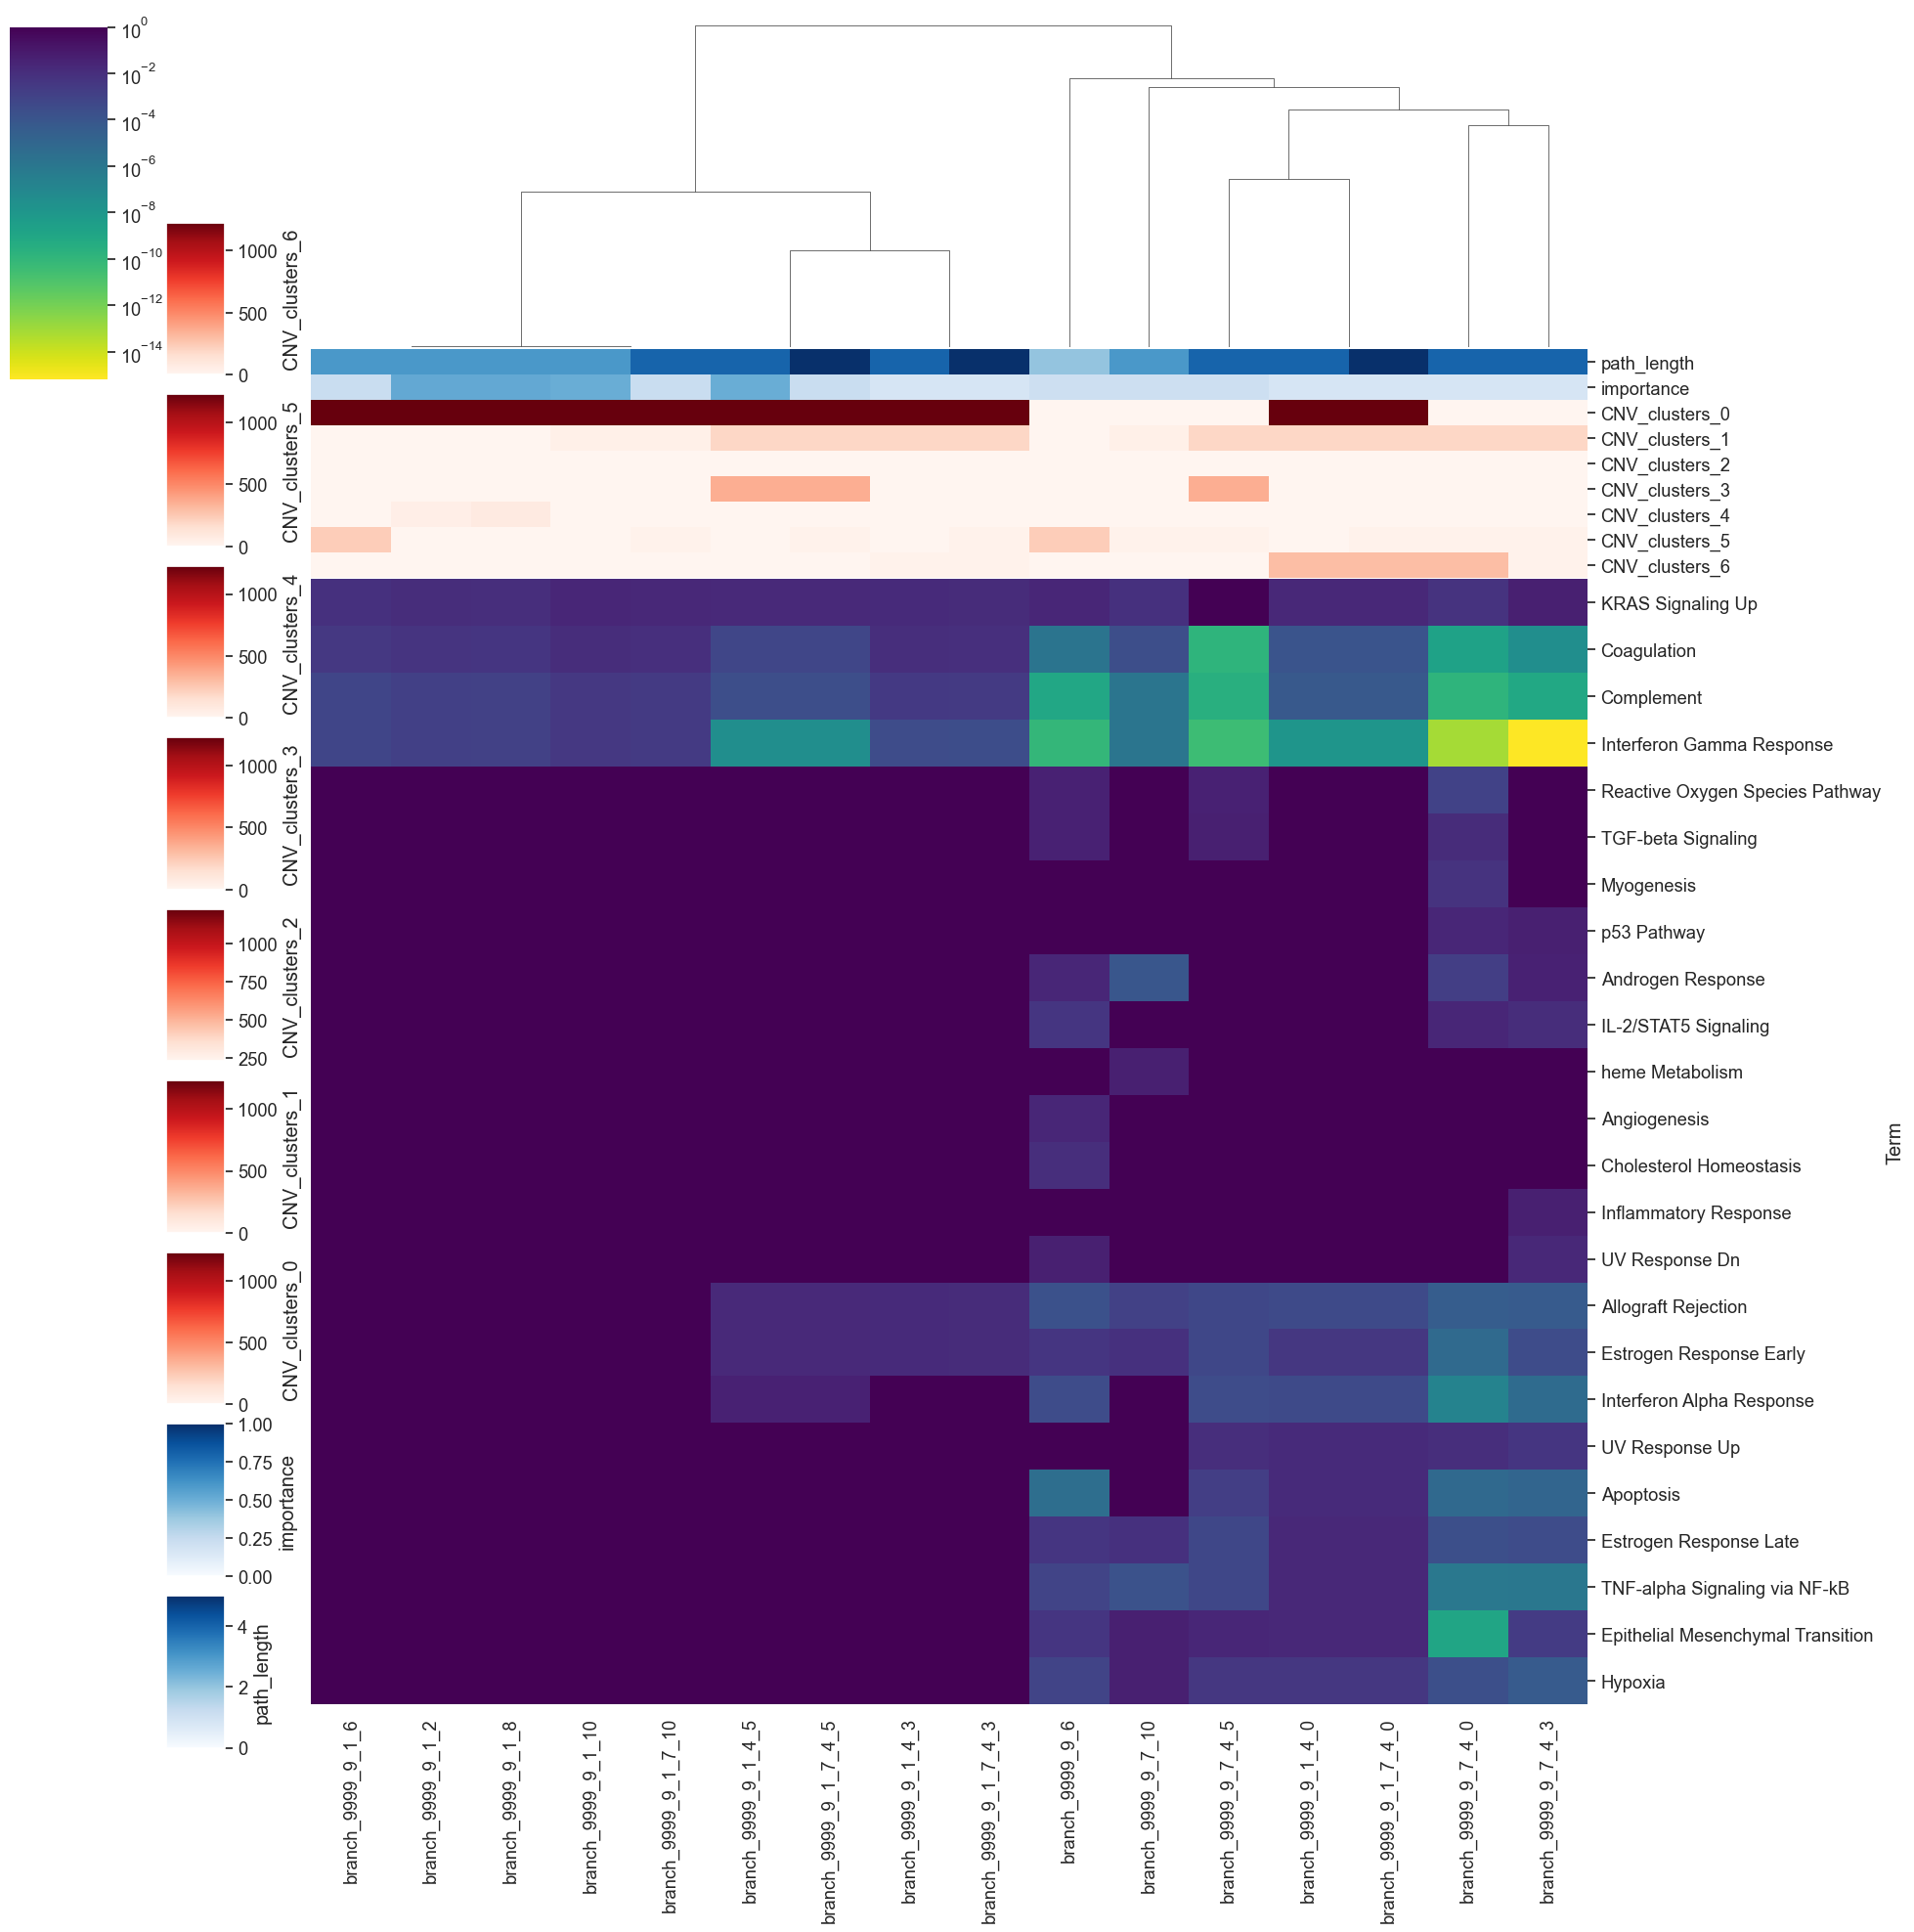

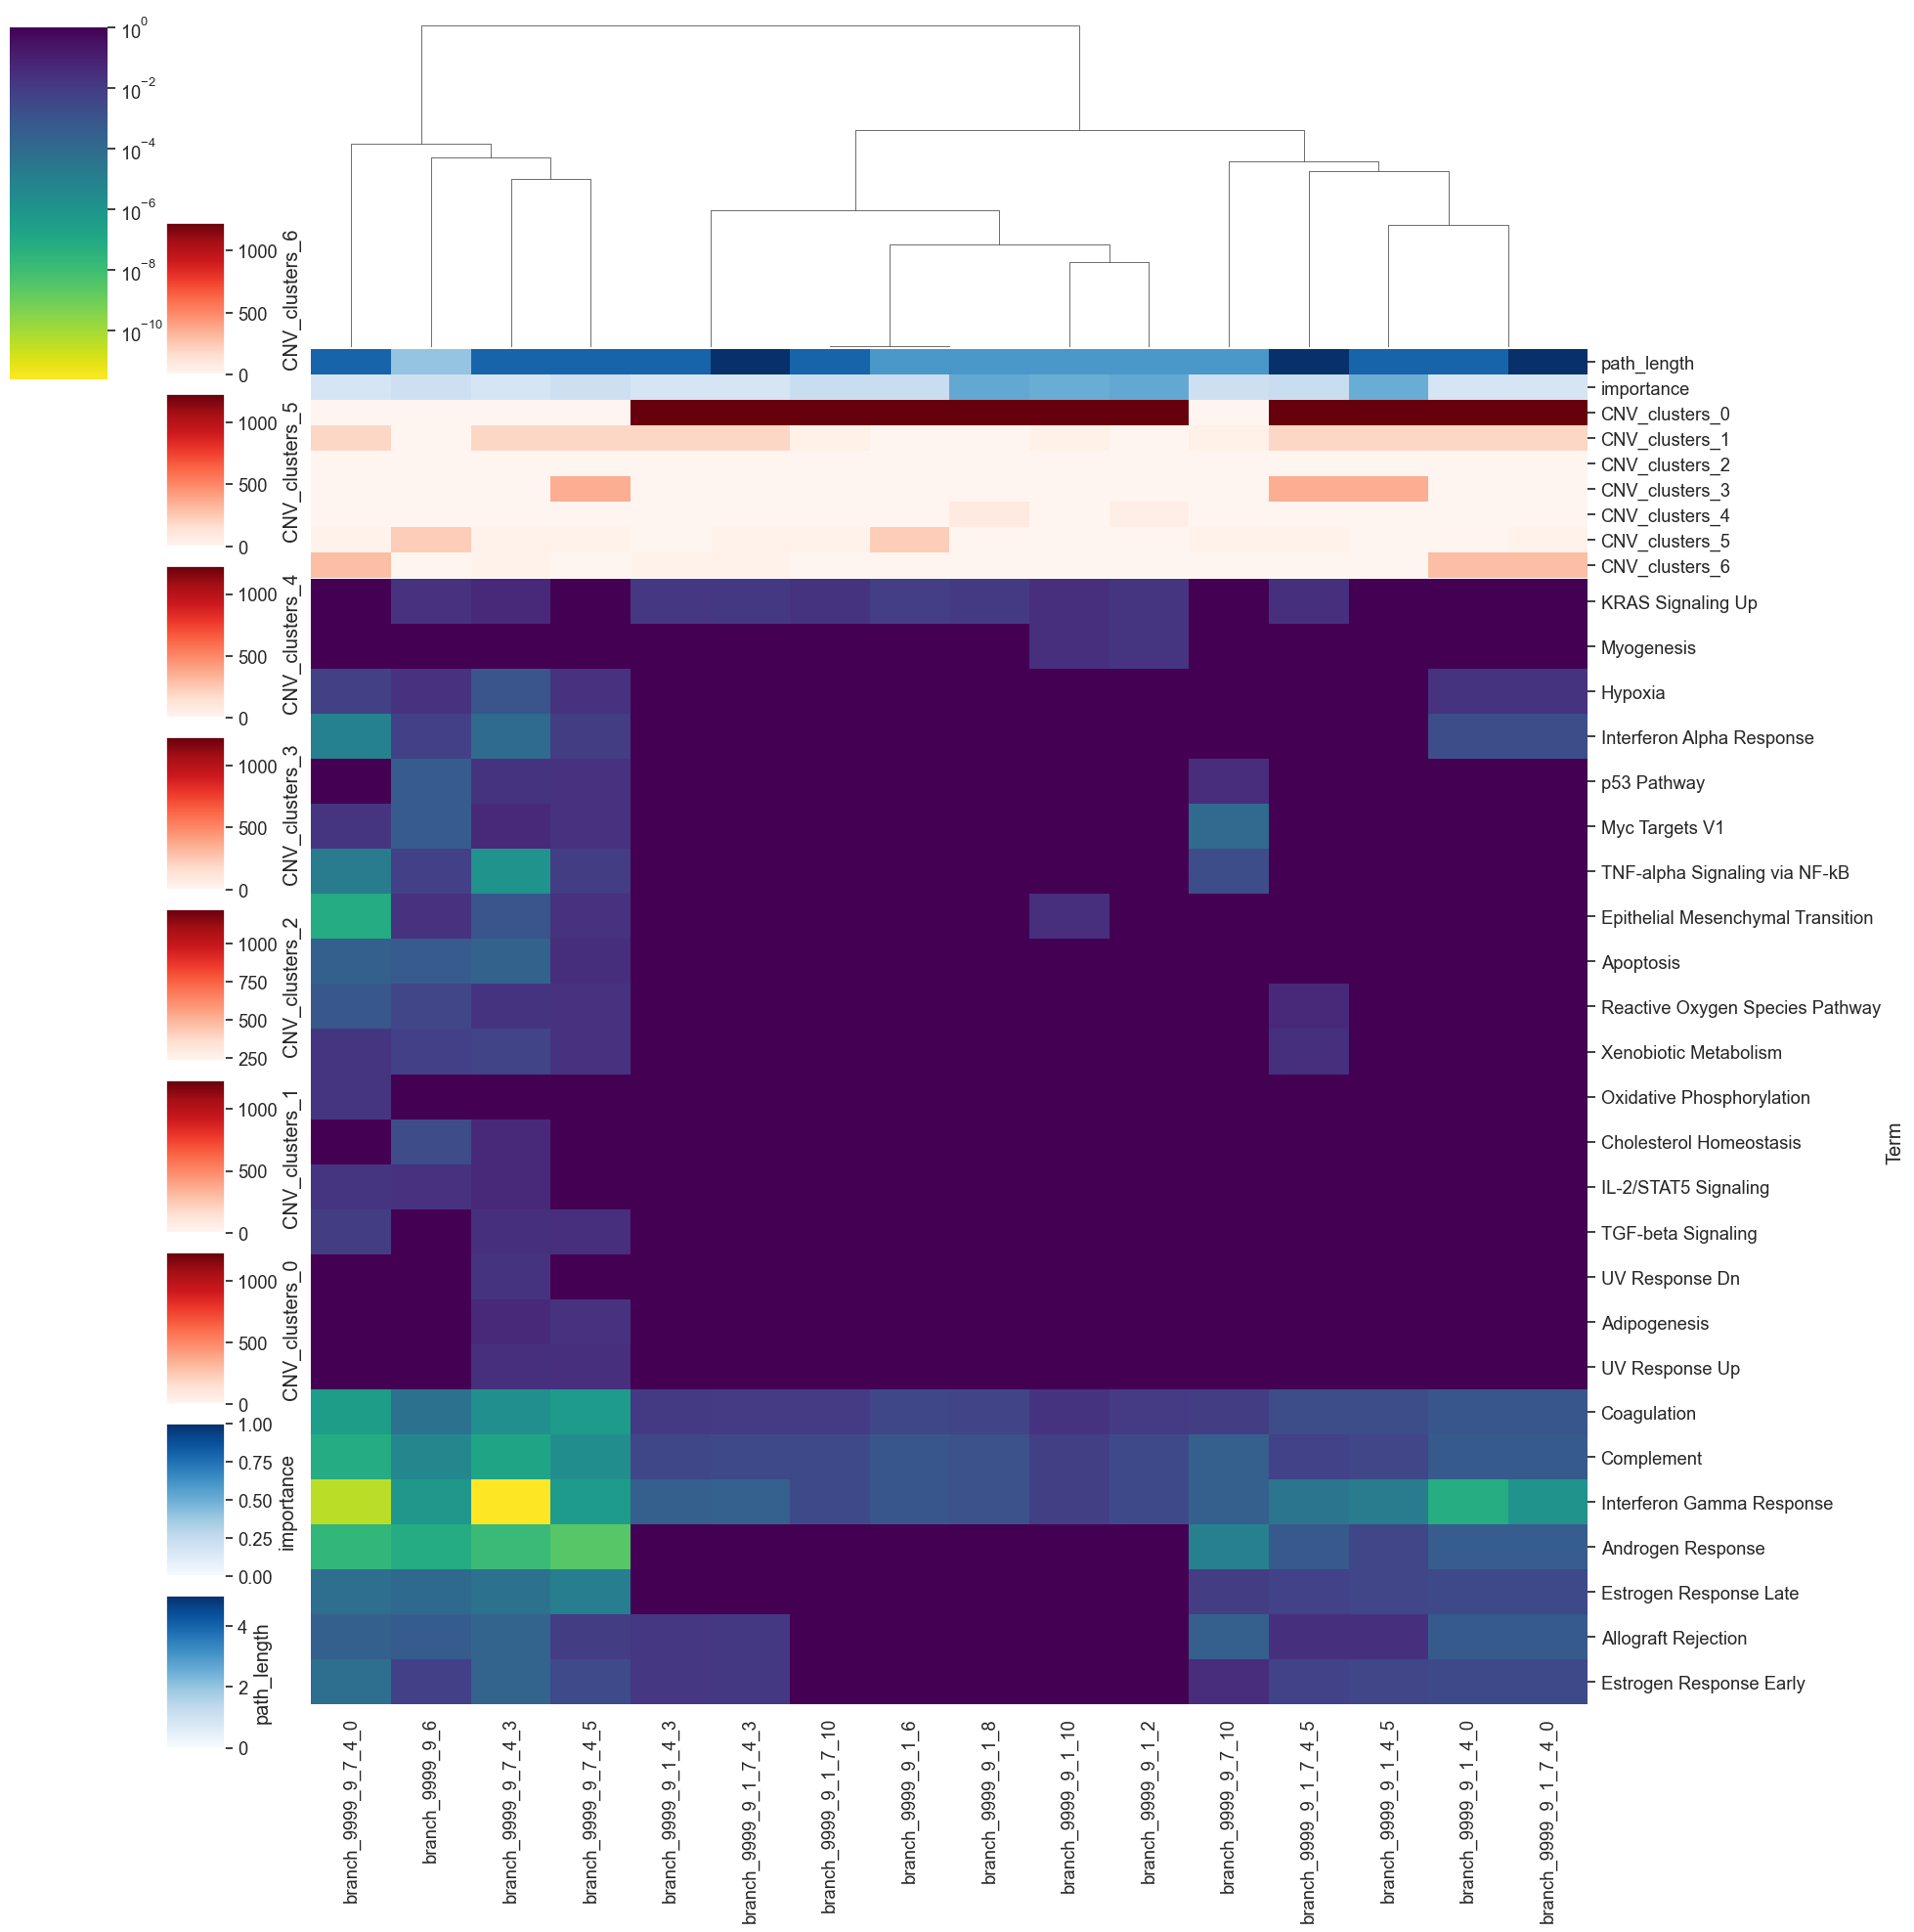

In [17]:
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib.pyplot import gcf

sns.set(font_scale=1.2)

for score_dir in ['up' ,'down', 'abs']:
    print(score_dir)
    col_colors_list = list()
    cmap_list = list()
    norm_list = list()
    for columns in branch_summary.columns:
        column_labels = branch_summary[columns][branch_summary.index]
    
    
        # Create a normalizer
        if columns == 'importance':
            cmap = plt.get_cmap('Blues')
            norm = mcolors.Normalize(vmin=0, vmax=1)
        elif columns == 'path_length':
            cmap = plt.get_cmap('Blues')
            norm = mcolors.Normalize(vmin=0, vmax=column_labels.max())
        else:
            cmap = plt.get_cmap('Reds')
            temp = np.max(branch_summary[list(filter(lambda x: x.startswith(use_label), branch_summary.columns))])
            norm = mcolors.Normalize(vmin=column_labels.min(), vmax=temp)
    
        cmap_list.append(cmap)
        norm_list.append(norm)
        # Apply the colormap to the values
        col_colors = pd.DataFrame({columns: column_labels.map(lambda x: cmap(norm(x)))})
        col_colors_list.append(col_colors)
    
    col_colors = pd.concat(col_colors_list, axis = 1)


    g = sns.clustermap(pathway_enrichment[score_dir], norm=LogNorm(), figsize = (20,20), cmap="viridis_r",
                        row_cluster=True, col_cluster=True, col_colors=col_colors, colors_ratio=0.015
                        )
    plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90)

    # Add a colorbar
    position_gap = 0.7 / len(branch_summary.columns)
    for i in range(len(branch_summary.columns)):
        ax_colorbar = g.fig.add_axes([.1, .1 + i * position_gap + i * 0.01, .03, position_gap])  # Adjust the values for positioning and size
        sm = plt.cm.ScalarMappable(cmap=cmap_list[i], norm=norm_list[i])
        sm.set_array([])
        g.fig.colorbar(sm, cax=ax_colorbar, orientation='vertical', label=branch_summary.columns[i])
        g.ax_row_dendrogram.set_visible(False)
